# PROJET FINAL MIFO 2023-2024, OMARI Akram MSROE.

The given fucntions are made with matlab so a translation to python is made at first. 

Step 1: Import Libraries

In [28]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import newton
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
from scipy.stats import norm
import matplotlib.pyplot as plt

Step 2: Define the computeDynamicConstants Function

In [29]:
import numpy as np

def computeDynamicConstants(m, zeta, fs):
    """
    Calculates the elastic stiffness, natural frequency, and viscous damping coefficient
    for a dynamic system based on mass, damping ratio, and force-displacement data.

    Parameters:
    - m: Mass of the system (scalar, positive).
    - zeta: Damping ratio (scalar, nonnegative, <= 1).
    - fs: Force-displacement data for the backbone curve (2-row numpy array with positive values).

    Returns:
    - omega_n: Natural angular frequency of the system.
    - c: Viscous damping coefficient.
    - ke: Elastic spring stiffness.
    """
    # Validate inputs (omitted for brevity; in practice, consider checking the conditions as in MATLAB)
    
    # Elastic spring stiffness (slope of the initial segment of the backbone curve)
    ke = fs[1, 0] / fs[0, 0]
    
    # Natural angular frequency of elastic system
    omega_n = np.sqrt(ke / m)
    
    # Viscous damping coefficient (assumed to be constant even if spring yields)
    c = 2 * zeta * m * omega_n
    
    return omega_n, c, ke

Step 3: Define the computeTimeStepSize Function

In [30]:
import numpy as np
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq

def computeTimeStepSize(t_range, omega_n, p, nonlinear=False):
    """
    Computes an appropriate time step size for numerical integration of a dynamic system.

    Parameters:
    - t_range: Tuple indicating the time range for the simulation.
    - omega_n: Natural angular frequency of the system.
    - p: External force as a function of time.
    - nonlinear: Boolean indicating if the problem is nonlinear.

    Returns:
    - dt: Computed time step size.
    """
    # Use the largest between natural frequency and frequency of forcing function
    omega = max(omega_n, maxForcingFrequency(t_range, p))
    
    # Compute time step size using a coefficient of '1/10' for linear and '1/20' for nonlinear systems
    dt = (1 / 10 - nonlinear / 20) * 2 * np.pi / omega
    
    # Round 'dt' down to nearest half order of magnitude
    halfmag = 10 ** (np.sign(np.log10(dt)) * np.floor(np.abs(np.log10(dt)) + 1)) / 2
    dt = np.floor(dt / halfmag) * halfmag
    
    return dt

def maxForcingFrequency(t_range, p):
    """
    Determines the maximum significant frequency of the forcing function using FFT.

    Parameters:
    - t_range: Tuple indicating the time range for the simulation.
    - p: External force as a function of time.

    Returns:
    - omegaBar: Maximum significant angular frequency of the forcing function.
    """
    # Generate a time mesh and evaluate the forcing function
    t = np.linspace(t_range[0], t_range[1], int(1e5))
    force_values = p(t)
    
    # Perform FFT and calculate frequency bins
    force_fft = np.abs(fft(force_values))
    frequencies = fftfreq(t.size, d=(t[1] - t[0])) * 2 * np.pi  # Angular frequencies
    
    # Ignore small amplitudes considered insignificant (less than 1% of the max amplitude)
    significant_amplitude_threshold = np.max(force_fft) / 100
    significant_indices = np.where(force_fft >= significant_amplitude_threshold)[0]
    
    # Find peaks in the FFT spectrum of significant amplitudes
    peaks, _ = find_peaks(force_fft[significant_indices])
    
    # Get the maximum frequency among the significant peaks
    omegaBar = np.max(frequencies[significant_indices][peaks]) if peaks.size > 0 else 0
    
    return omegaBar

# Example usage of p(t), defining a sinusoidal forcing function
def p(t):
    return np.sin(2 * np.pi * 2 * t)  # Example: sinusoidal force with frequency of 2 Hz

# Compute time step size
dt = computeTimeStepSize((0, 10), 5, p, nonlinear=True)
print(f"Computed time step size: {dt}")

Computed time step size: 0.06


Step 4: Define the linear_interpolation Function

In [31]:
import numpy as np
from scipy.interpolate import interp1d

def linear_interpolation(x, f, p, extrapolate=False):
    """
    Linearly interpolates or extrapolates a function defined by abscissa-ordinate pairs.

    Parameters:
    - x: Abscissa values (increasing order).
    - f: Corresponding ordinate values.
    - p: Target point for which the function value is sought.
    - extrapolate: If True, allows extrapolation outside the domain of x.

    Returns:
    - fx: The interpolated or extrapolated value of the function at p.
    """
    # Validate inputs
    if not extrapolate and (p < x[0] or p > x[-1]):
        raise ValueError("The specified target point is outside the provided domain of abscissa values. "
                         "Set extrapolate=True to allow extrapolation.")

    # Setup the interpolation function
    interp_func = interp1d(x, f, fill_value='extrapolate' if extrapolate else None, bounds_error=not extrapolate)

    # Compute and return the interpolated or extrapolated value
    fx = interp_func(p)
    return fx

Step 5: Define the newton_solve Function

In [32]:
import numpy as np

def newton_solve(f, p, max_it, R_tol, secant=True, console=True):
    """
    Solves f(x) = 0 using the Newton-Raphson method or secant method with finite differences.

    Parameters:
    - f: The function for which the root is sought.
    - p: Initial guess array with two elements for the root.
    - max_it: Maximum number of iterations.
    - R_tol: Residual tolerance for convergence.
    - secant: If True, use secant (finite differences) updates; otherwise, assume constant df/dx.
    - console: If True, print convergence information to the console.

    Returns:
    - x: The computed root of f(x) = 0.
    """
    # Compute residuals at initial guesses
    q = np.array([f(p_i) for p_i in p])
    df = (q[1] - q[0]) / (p[1] - p[0])  # Initial secant (finite difference)
    n = 1  # Iteration counter

    while n <= max_it:
        # Compute root of secant line and evaluate residual
        x = p[1] - q[1] / df
        R = f(x)

        # Check for convergence
        if abs(R) <= R_tol:
            if console:
                print(f"Newton solver converged at R = {R} with {n} iterations.")
            return x

        # Update guesses and residuals
        p[0], q[0] = p[1], q[1]
        p[1], q[1] = x, R

        # Check if root estimate is stalling
        if q[1] == q[0]:
            raise ValueError(f"Newton solver has stalled. Current residual is R = {R}.")

        # Update finite difference if using secant method
        if secant:
            df = (q[1] - q[0]) / (p[1] - p[0])

        n += 1

    # Solver failed to converge
    raise ValueError(f"Newton solver failed to converge within {max_it} iterations. Current residual is R = {R}.")

# Example usage:
def my_func(x):
    return x**2 - 4  # Example function for which we seek the root

# Initial guesses for the root
initial_guesses = [1, 2]

# Call the solver
root = newton_solve(my_func, initial_guesses, 100, 1e-6, secant=True, console=True)
print(f"Found root: {root}")

Newton solver converged at R = 0.0 with 1 iterations.
Found root: 2.0


Step 6: Implement the solveEquationOfMotion Function

In [33]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import newton

def solveEquationOfMotion(m, c, fs, ke, t, dt, du_initial, u_initial, p, **kwargs):
    # Validate inputs
    gamma = kwargs.get('gamma', 0.5)
    beta = kwargs.get('beta', 0.25)
    max_it = kwargs.get('MaxIterations', 20)
    R_tol = kwargs.get('ResidualTol', 1e-12)
    is_updated = kwargs.get('UpdateStiffness', True)
    console = kwargs.get('Console', True)
    
    # Store upper and lower isotropic yield points
    uy_top = fs[0, 0]
    uy_bot = -uy_top
    fy_top = fs[1, 0]
    fy_bot = -fy_top
    
    # Reflect supplied backbone through horizontal and vertical axes and combine with original
    fs = np.hstack((-np.flip(fs, axis=1), fs))
    
    # Allocate arrays
    t = np.arange(t[0], t[1] + dt, dt)
    N = len(t)
    d2u = np.zeros(N)
    du = np.zeros(N)
    u = np.zeros(N)
    fs_history = np.zeros(N)
    
    # Set initial conditions
    du[0] = du_initial
    u[0] = u_initial
    fs_history[0] = interp1d(fs[0, :], fs[1, :], fill_value='extrapolate')(u[0])
    d2u[0] = (p(t[0]) - c * du[0] - fs_history[0]) / m
    
    # Compute constants
    a = np.array([1 / (2 * beta) - 1, 1 / (beta * dt), 1 / (beta * dt ** 2), 
                  dt * (gamma / (2 * beta) - 1), gamma / beta - 1])
    a = np.append(a, gamma * a[1])
    b = m * a[:3] + c * a[3:6]
    
    k = ke
    yielded = False
    
    for i in range(N - 1):
        if console:
            print(f'Time = {t[i]}')
        
        const = p(t[i + 1]) + b[0] * d2u[i] + b[1] * du[i] + b[2] * u[i]
        
        if yielded and (delta_u * (const / (k + b[2]) - u[i]) <= np.cbrt(R_tol)):
            if fs_history[i] >= 0:
                horizontal_shift = u[i] - uy_top
                vertical_shift = fs_history[i] - fy_top
            else:
                horizontal_shift = u[i] - uy_bot
                vertical_shift = fs_history[i] - fy_bot
            
            fs[0, :] += horizontal_shift
            fs[1, :] += vertical_shift
            
            uy_top += horizontal_shift
            fy_top += vertical_shift
            uy_bot += horizontal_shift
            fy_bot += vertical_shift
            
            k = ke
            yielded = False
        
        u_trial = [u[i], const / (k + b[2])]
        R = lambda u: (const - b[2] * u - interp1d(fs[0, :], fs[1, :], fill_value='extrapolate')(u))
        u[i + 1] = newton(R, u_trial[1], maxiter=max_it, tol=R_tol)
        
        delta_u = u[i + 1] - u[i]
        fs_history[i + 1] = interp1d(fs[0, :], fs[1, :], fill_value='extrapolate')(u[i + 1])
        k = (fs_history[i + 1] - fs_history[i]) / delta_u
        
        if not yielded and (abs(k - ke) / ke >= R_tol):
            yielded = True
        
        d2u[i + 1] = -a[0] * d2u[i] - a[1] * du[i] + a[2] * delta_u
        du[i + 1] = -a[3] * d2u[i] - a[4] * du[i] + a[5] * delta_u
    
    if console:
        print(f'Time = {t[N - 1]}\n\nSOLVE COMPLETE!\n')
        print('--------------------------------------------------------------\n\n')
    
    return t, d2u, du, u, fs_history

Step 6: chopraEx55_mifo

In [34]:
def chopraEx55_mifo(m, r, c1, c2, t1, F1):
    # Acceleration due to gravity
    g = 0
    # Critical damping ratio
    zeta = 0.05
    # Restoring force backbone
    fs = np.array([[r, 15 * r], [r * c1, 14 * c2 * r + r * c1]])  # kN
    # Time domain
    t = np.array([0, 5 * t1])  # s
    # Time step size
    dt = 0.01  # s
    # Initial conditions
    du_init = 0
    u_init = 0
    # Forcing function
    p = lambda t: F1 if t < t1 else 0  # kN
    # Residual tolerance
    R_tol = 1e-03
    # Units
    units = ['s', 'cm', 'kN']

    # Compute dynamic constants
    omega_n, c, ke = computeDynamicConstants(m, zeta, fs)
    # Determine time step size
    if dt == 0:
        dt = computeTimeStepSize(t, omega_n, p, 'Nonlinear', len(fs[0]) > 1)
    # Add static initialization to displacement initial condition
    u_init += m * g / ke
    # Solve equation of motion using Newmark-beta and Newton-Raphson methods
    t, d2u, du, u, fs_history = solveEquationOfMotion(m, c, fs, ke, t, dt, du_init, u_init, p,
                                                      gamma=0.5, beta=0.25, MaxIterations=20, ResidualTol=R_tol,
                                                      UpdateStiffness=True, Console=True)

    return t, d2u, du, u, fs_history

# Task 1 - Generate the dataset [T1]

## T1.1 the variables in Table 1 are all independent random variables and log-normally distributed (LDB1)

Task 1.1 of the script is dedicated to generating a dataset for the Learning DataBase (LDB1) used in metamodeling the behavior of a bilinear SDOF system. It calculates log-normally distributed random variables corresponding to the system's parameters, compiles them into a structured DataFrame (LDB1), and computes the probability of failure by evaluating a limit state function across multiple simulations. This task is foundational for assessing the reliability of the SDOF system under variable load conditions.

Time = 0.0
Time = 0.01
Time = 0.02
Time = 0.03
Time = 0.04
Time = 0.05
Time = 0.06
Time = 0.07
Time = 0.08
Time = 0.09
Time = 0.1
Time = 0.11
Time = 0.12
Time = 0.13
Time = 0.14
Time = 0.15
Time = 0.16
Time = 0.17
Time = 0.18
Time = 0.19
Time = 0.2
Time = 0.21
Time = 0.22
Time = 0.23
Time = 0.24
Time = 0.25
Time = 0.26
Time = 0.27
Time = 0.28
Time = 0.29
Time = 0.3
Time = 0.31
Time = 0.32
Time = 0.33
Time = 0.34
Time = 0.35000000000000003
Time = 0.36
Time = 0.37
Time = 0.38
Time = 0.39
Time = 0.4
Time = 0.41000000000000003
Time = 0.42
Time = 0.43
Time = 0.44
Time = 0.45
Time = 0.46
Time = 0.47000000000000003
Time = 0.48
Time = 0.49
Time = 0.5
Time = 0.51
Time = 0.52
Time = 0.53
Time = 0.54
Time = 0.55
Time = 0.56
Time = 0.5700000000000001
Time = 0.58
Time = 0.59
Time = 0.6
Time = 0.61
Time = 0.62
Time = 0.63
Time = 0.64
Time = 0.65
Time = 0.66
Time = 0.67
Time = 0.68
Time = 0.6900000000000001
Time = 0.7000000000000001
Time = 0.71
Time = 0.72
Time = 0.73
Time = 0.74
Time = 0.75
Time = 0

Time = 3.81
Time = 3.8200000000000003
Time = 3.83
Time = 3.84
Time = 3.85
Time = 3.86
Time = 3.87
Time = 3.88
Time = 3.89
Time = 3.9
Time = 3.91
Time = 3.92
Time = 3.93
Time = 3.94
Time = 3.95
Time = 3.96
Time = 3.97
Time = 3.98
Time = 3.99
Time = 4.0
Time = 4.01
Time = 4.0200000000000005
Time = 4.03
Time = 4.04
Time = 4.05
Time = 4.0600000000000005
Time = 4.07
Time = 4.08
Time = 4.09
Time = 4.1
Time = 4.11
Time = 4.12
Time = 4.13
Time = 4.14
Time = 4.15
Time = 4.16
Time = 4.17
Time = 4.18
Time = 4.19
Time = 4.2
Time = 4.21
Time = 4.22
Time = 4.23
Time = 4.24
Time = 4.25
Time = 4.26
Time = 4.2700000000000005
Time = 4.28
Time = 4.29
Time = 4.3
Time = 4.3100000000000005
Time = 4.32
Time = 4.33
Time = 4.34
Time = 4.3500000000000005

SOLVE COMPLETE!

--------------------------------------------------------------


Time = 0.0
Time = 0.01
Time = 0.02
Time = 0.03
Time = 0.04
Time = 0.05
Time = 0.06
Time = 0.07
Time = 0.08
Time = 0.09
Time = 0.1
Time = 0.11
Time = 0.12
Time = 0.13
Time = 0.14


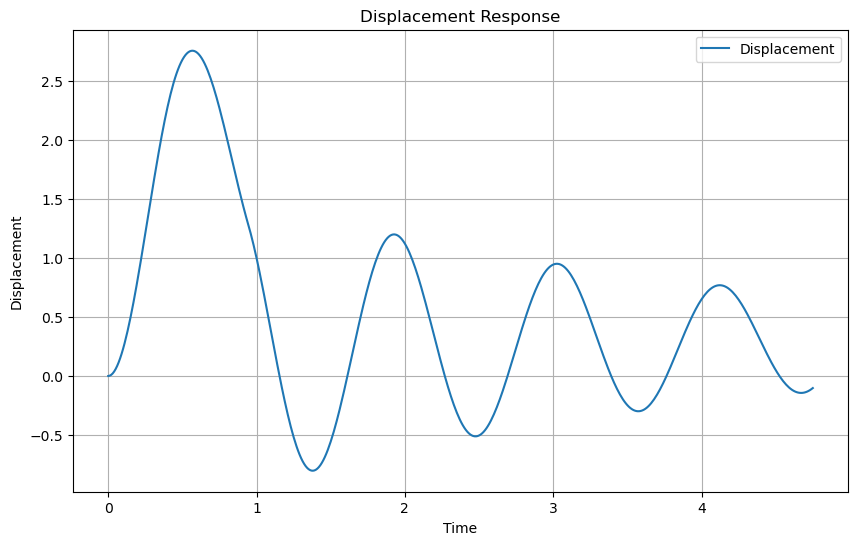

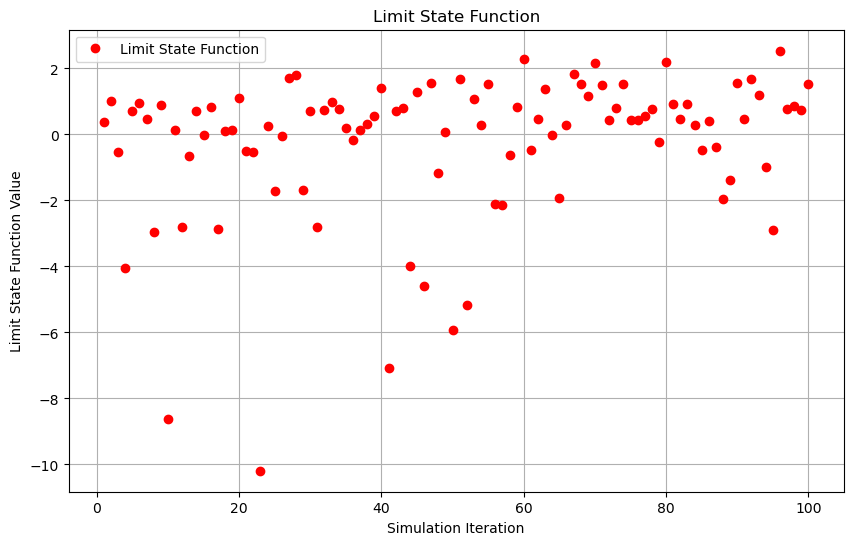

In [35]:
import numpy as np
from scipy.stats import norm, lognorm

N = 100
f = 25  # kN
CV_f_1 = 0.2
fsi = f * CV_f_1

t_1 = 1  # s
CV_t_1 = 0.2
tsi = t_1 * CV_t_1

M = 0.46  # KN/cm
CV_M = 0.05
Msi = M * CV_M

K_1 = 18  # kN.s^2/cm
CV_K_1 = 0.1
k1si = K_1 * CV_K_1

K_2 = 1.8  # kN.s^2/cm
CV_K_2 = 0.1
k2si = K_2 * CV_K_2

delta_y = 2  # cm
CV_delta_y = 0.1
deltasi = delta_y * CV_delta_y
delta_u = 8 * delta_y  # cm
amortissement = 0.05

# Random variables generation
np.random.seed(0)  # For reproducibility


u1 = np.random.rand(N)
u2 = np.random.rand(N)
u3 = np.random.rand(N)
u4 = np.random.rand(N)
u5 = np.random.rand(N)
u6 = np.random.rand(N)
u7 = np.random.rand(N)

x1 = norm.ppf(u1, loc=0, scale=1)
x2 = norm.ppf(u2, loc=0, scale=1)
x3 = norm.ppf(u3, loc=0, scale=1)
x4 = norm.ppf(u4, loc=0, scale=1)
x5 = norm.ppf(u5, loc=0, scale=1)
x6 = norm.ppf(u6, loc=0, scale=1)
x7 = norm.ppf(u7, loc=0, scale=1)

fxi = np.sqrt(np.log(1 + (fsi / f) ** 2))
flambda = np.log(f - 0.5 * fxi ** 2)
fvar = np.exp(flambda + fxi * x2)

txi = np.sqrt(np.log(1 + (tsi / t_1) ** 2))
tlambda = np.log(t_1 - 0.5 * txi ** 2)
tvar = np.exp(tlambda + txi * x2)

Mxi = np.sqrt(np.log(1 + (Msi / M) ** 2))
Mlambda = np.log(M - 0.5 * Mxi ** 2)
Mvar = np.exp(Mlambda + Mxi * x3)

K1xi = np.sqrt(np.log(1 + (k1si / K_1) ** 2))
k1lambda = np.log(K_1 - 0.5 * K1xi ** 2)
K1var = np.exp(k1lambda + K1xi * x4)

K2xi = np.sqrt(np.log(1 + (k2si / K_2) ** 2))
k2lambda = np.log(K_2 - 0.5 * K2xi ** 2)
K2var = np.exp(k2lambda + K2xi * x5)

delta_yxi = np.sqrt(np.log(1 + (deltasi / delta_y) ** 2))
delta_ylambda = np.log(delta_y - 0.5 * delta_yxi ** 2)
deltayvar = np.exp(delta_ylambda + delta_yxi * x6)

Base = np.column_stack((fvar, tvar, Mvar, K1var, K2var, deltayvar))

dallow = np.maximum(3 * np.log(deltayvar), 0.6 * 8 * np.log(deltayvar))
# Initialize arrays to store the maximum displacements and failure indicator values
max_disp_1 = np.zeros(N)
g = np.zeros(N)
for i in range(N):
    # Call chopraEx55mifo function to get displacement 'u'
    t, d2u, du, u, fs_history = chopraEx55_mifo(Base[i, 2], Base[i, 5], Base[i, 3], Base[i, 4], Base[i, 1], Base[i, 0])
    utop1 = np.max(u)  # Capture the maximum displacement from the current simulation
    max_disp_1[i] = utop1  # Store the maximum displacement
    umin = np.min(u)
    g[i] = (np.maximum(3 * np.log(deltayvar[i]), 0.6 * 8 * np.log(deltayvar[i])) - utop1)
    
# Probablity of Failure
pt = np.where(g <= 0)[0]
probability_of_failure = len(pt) / N
print("Probability of failure:", probability_of_failure)

# Convert the Base array to a DataFrame for LDB1
LDB1 = pd.DataFrame(Base, columns=['f', 't', 'M', 'K1', 'K2', 'delta_y'])
# Add the max_disp_1 column to the DataFrame
LDB1['utop'] = max_disp_1

# Display the first few rows of the DataFrame
print(LDB1.head())

import matplotlib.pyplot as plt

# Plot displacement response
plt.figure(figsize=(10, 6))
plt.plot(t, u, label='Displacement')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('Displacement Response')
plt.grid(True)
plt.legend()
plt.show()

# Plot limit state function
plt.figure(figsize=(10, 6))
plt.plot(range(1, N + 1), g, 'ro', label='Limit State Function')
plt.xlabel('Simulation Iteration')
plt.ylabel('Limit State Function Value')
plt.title('Limit State Function')
plt.grid(True)
plt.legend()
plt.show()




## T1.2 the variables in Table 1 are all log-normally distributed but two  K1 ,  K2 , with correlation coefficients  ρK1,K2 =0.8 (LDB2)

Task 1.2 extends the dataset generation process of Task 1.1 by introducing correlation between two key mechanical properties of the SDOF system, K1 and K2, while maintaining the log-normal distribution of all variables. This task creates the Learning DataBase (LDB2), which includes this correlation, essential for modeling the system's behavior more realistically. The script generates the correlated dataset, simulates the system's response, calculates the limit state function, and determines the failure probability, accounting for the dependence between the elastic and plastic stiffness parameters.

Time = 0.0
Time = 0.01
Time = 0.02
Time = 0.03
Time = 0.04
Time = 0.05
Time = 0.06
Time = 0.07
Time = 0.08
Time = 0.09
Time = 0.1
Time = 0.11
Time = 0.12
Time = 0.13
Time = 0.14
Time = 0.15
Time = 0.16
Time = 0.17
Time = 0.18
Time = 0.19
Time = 0.2
Time = 0.21
Time = 0.22
Time = 0.23
Time = 0.24
Time = 0.25
Time = 0.26
Time = 0.27
Time = 0.28
Time = 0.29
Time = 0.3
Time = 0.31
Time = 0.32
Time = 0.33
Time = 0.34
Time = 0.35000000000000003
Time = 0.36
Time = 0.37
Time = 0.38
Time = 0.39
Time = 0.4
Time = 0.41000000000000003
Time = 0.42
Time = 0.43
Time = 0.44
Time = 0.45
Time = 0.46
Time = 0.47000000000000003
Time = 0.48
Time = 0.49
Time = 0.5
Time = 0.51
Time = 0.52
Time = 0.53
Time = 0.54
Time = 0.55
Time = 0.56
Time = 0.5700000000000001
Time = 0.58
Time = 0.59
Time = 0.6
Time = 0.61
Time = 0.62
Time = 0.63
Time = 0.64
Time = 0.65
Time = 0.66
Time = 0.67
Time = 0.68
Time = 0.6900000000000001
Time = 0.7000000000000001
Time = 0.71
Time = 0.72
Time = 0.73
Time = 0.74
Time = 0.75
Time = 0

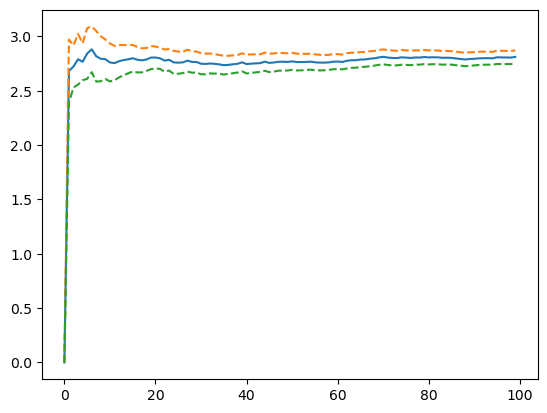

Failure probabilities (pf%): 57.99999999999999


In [36]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define parameters
N = 100
f = 25  # kN
CV_f_1 = 0.2
fsi = f * CV_f_1

t_1 = 1  # s
CV_t_1 = 0.2
tsi = t_1 * CV_t_1

M = 0.46  # KN/cm
CV_M = 0.05
Msi = M * CV_M

K_1 = 18  # kN.s2/cm
CV_K_1 = 0.1
k1si = K_1 * CV_K_1

K_2 = 1.8  # kN.s2/cm
CV_K_2 = 0.1
k2si = K_2 * CV_K_2

delta_y = 2  # cm
CV_delta_y = 0.1
deltasi = delta_y * CV_delta_y
delta_u = 8 * delta_y  # cm
amortissement = 0.05

# Correlation coefficient for K1 and K2
rho_K1_K2 = 0.8
# Generate random variables
np.random.seed(0)  # For reproducibility

# Generate random variables
u1 = np.random.rand(N)
u2 = np.random.rand(N)
u3 = np.random.rand(N)
u4 = np.random.rand(N)
u5 = np.random.rand(N)
u6 = np.random.rand(N)
u7 = np.random.rand(N)

# Generate N[0, 1]
x1 = stats.norm.ppf(u1, loc=0, scale=1)
x2 = stats.norm.ppf(u2, loc=0, scale=1)
x3 = stats.norm.ppf(u3, loc=0, scale=1)
x4 = stats.norm.ppf(u4, loc=0, scale=1)
x5 = stats.norm.ppf(u5, loc=0, scale=1)
x6 = stats.norm.ppf(u6, loc=0, scale=1)
x7 = stats.norm.ppf(u7, loc=0, scale=1)

# Calculate random variables based on lognormal distribution formulas
fxi = np.sqrt(np.log(1 + (fsi / f) ** 2))
flambda = np.log(f - 0.5 * fxi ** 2)
fvar = np.exp(flambda + fxi * x2)

txi = np.sqrt(np.log(1 + (tsi / t_1) ** 2))
tlambda = np.log(t_1 - 0.5 * txi ** 2)
tvar = np.exp(tlambda + txi * x2)

Mxi = np.sqrt(np.log(1 + (Msi / M) ** 2))
Mlambda = np.log(M - 0.5 * Mxi ** 2)
Mvar = np.exp(Mlambda + Mxi * x3)

K1xi = np.sqrt(np.log(1 + (k1si / K_1) ** 2))
k1lambda = np.log(K_1 - 0.5 * K1xi ** 2)
K1var = np.exp(k1lambda + K1xi * x4)

K2xi = np.sqrt(np.log(1 + (k2si / K_2) ** 2))
k2lambda = np.log(K_2 - 0.5 * K2xi ** 2)
K2var = np.exp(k2lambda + K2xi * x5)

delta_yxi = np.sqrt(np.log(1 + (deltasi / delta_y) ** 2))
delta_ylambda = np.log(delta_y - 0.5 * delta_yxi ** 2)
deltayvar = np.exp(delta_ylambda + delta_yxi * x6)

# For K1 and K2, generate correlated standard normal variables
# Generate standard normal variables
std_normal_K1_K2 = np.random.randn(N, 2)

# Create correlation matrix for K1 and K2
correlation_matrix_K1_K2 = np.array([[1, rho_K1_K2], [rho_K1_K2, 1]])
# Perform Cholesky decomposition to create correlated variables
L = np.linalg.cholesky(correlation_matrix_K1_K2)
correlated_normal_K1_K2 = std_normal_K1_K2.dot(L)

# Transform correlated standard normal variables into lognormal
K1xi = np.sqrt(np.log(1 + (k1si / K_1) ** 2))
k1lambda = np.log(K_1) - 0.5 * K1xi ** 2
K1var = np.exp(k1lambda + K1xi * correlated_normal_K1_K2[:, 0])

K2xi = np.sqrt(np.log(1 + (k2si / K_2) ** 2))
k2lambda = np.log(K_2) - 0.5 * K2xi ** 2
K2var = np.exp(k2lambda + K2xi * correlated_normal_K1_K2[:, 1])

# Model
Base1 = np.column_stack((fvar, tvar, Mvar, K1var, K2var, deltayvar))

dallow_values = []
utop_values = []

for i in range(N):
    _, _, _, u2_values, _ = chopraEx55_mifo(Base1[i, 2], Base1[i, 5], Base1[i, 3], Base1[i, 4], Base1[i, 1], Base1[i, 0])
    utop_values.append(u2_values)
    dallow = max(1.4 * deltayvar[i], 1 * deltayvar[i])
    dallow_values.append(dallow)

# Calculate the maximum displacement from each simulation
utop_values = [np.max(u2) for u2 in utop_values]

utop_2 = utop_values  # Maximum displacement from the second simulation

# Calculate the difference
g = np.array(dallow_values) - np.array(utop_values)

pt = np.where(g <= 0)[0]
pf = (len(pt) / N) * 100

CVp = np.sqrt((100 - pf) / ((N - 1) * pf)) * 100

# Confidence interval
muN = np.zeros(N)
stdev = np.zeros(N)
ICN = np.zeros(N)
Denom_p = np.zeros(N)
Denom_m = np.zeros(N)
Numera = np.zeros(N)
ICSTDN_p = np.zeros(N)
ICSTDN_m = np.zeros(N)

for j in range(1, N):
    muN[j] = np.mean(dallow_values[:j+1])
    ICN[j] = stats.t.ppf(0.975, j) * np.std(dallow_values[:j+1]) / np.sqrt(j)
    stdev[j] = np.std(dallow_values[:j+1])
    Denom_p[j] = stats.chi2.ppf(0.975, j)
    Denom_m[j] = stats.chi2.ppf(0.025, j)
    Numera[j] = (j) * np.var(dallow_values[:j+1])
    ICSTDN_p[j] = np.sqrt(Numera[j] / Denom_p[j])
    ICSTDN_m[j] = np.sqrt(Numera[j] / Denom_m[j])

# Convert the Base1 array to a DataFrame for LDB2
LDB2 = pd.DataFrame(Base1, columns=['f', 't', 'M', 'K1', 'K2', 'delta_y'])
# Store utop_values in LDB2
LDB2['utop'] = utop_values

# To display the first few rows of the DataFrame, you can use:
print(LDB2.head())

plt.figure()
plt.plot(muN, '-')
plt.plot(muN + ICN, '--')
plt.plot(muN - ICN, '--')
plt.show()

print("Failure probabilities (pf%):", pf)

## T1.3 the variables in Table 1 are all independent random variables and gumbel distributed (LDB3)

Task 1.3 involves generating a dataset (LDB3) where all the variables are independent and follow a Gumbel distribution, which is particularly suitable for modeling the distribution of extreme values. This task is critical for creating a robust database to predict the maximum response of a structural system under varying conditions, and it concludes with the calculation of the probability of failure to assess the system's reliability.

Time = 0.0
Time = 0.01
Time = 0.02
Time = 0.03
Time = 0.04
Time = 0.05
Time = 0.06
Time = 0.07
Time = 0.08
Time = 0.09
Time = 0.1
Time = 0.11
Time = 0.12
Time = 0.13
Time = 0.14
Time = 0.15
Time = 0.16
Time = 0.17
Time = 0.18
Time = 0.19
Time = 0.2
Time = 0.21
Time = 0.22
Time = 0.23
Time = 0.24
Time = 0.25
Time = 0.26
Time = 0.27
Time = 0.28
Time = 0.29
Time = 0.3
Time = 0.31
Time = 0.32
Time = 0.33
Time = 0.34
Time = 0.35000000000000003
Time = 0.36
Time = 0.37
Time = 0.38
Time = 0.39
Time = 0.4
Time = 0.41000000000000003
Time = 0.42
Time = 0.43
Time = 0.44
Time = 0.45
Time = 0.46
Time = 0.47000000000000003
Time = 0.48
Time = 0.49
Time = 0.5
Time = 0.51
Time = 0.52
Time = 0.53
Time = 0.54
Time = 0.55
Time = 0.56
Time = 0.5700000000000001
Time = 0.58
Time = 0.59
Time = 0.6
Time = 0.61
Time = 0.62
Time = 0.63
Time = 0.64
Time = 0.65
Time = 0.66
Time = 0.67
Time = 0.68
Time = 0.6900000000000001
Time = 0.7000000000000001
Time = 0.71
Time = 0.72
Time = 0.73
Time = 0.74
Time = 0.75
Time = 0

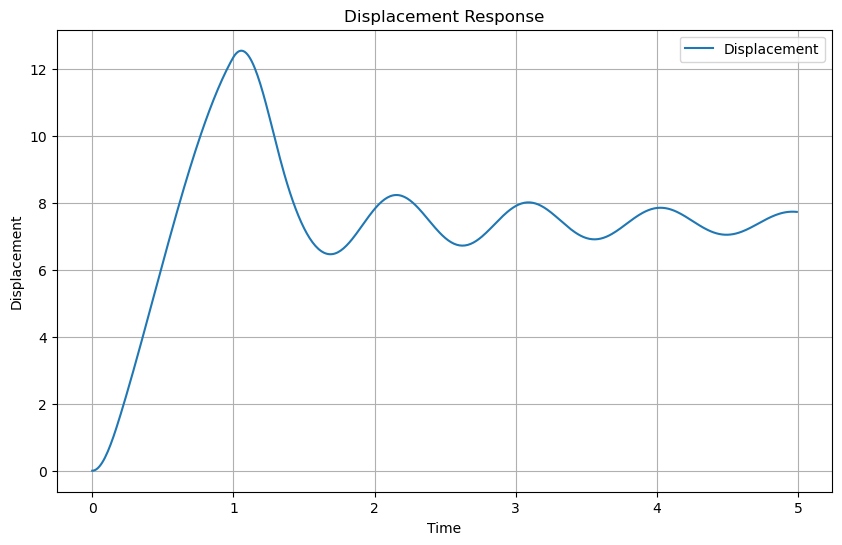

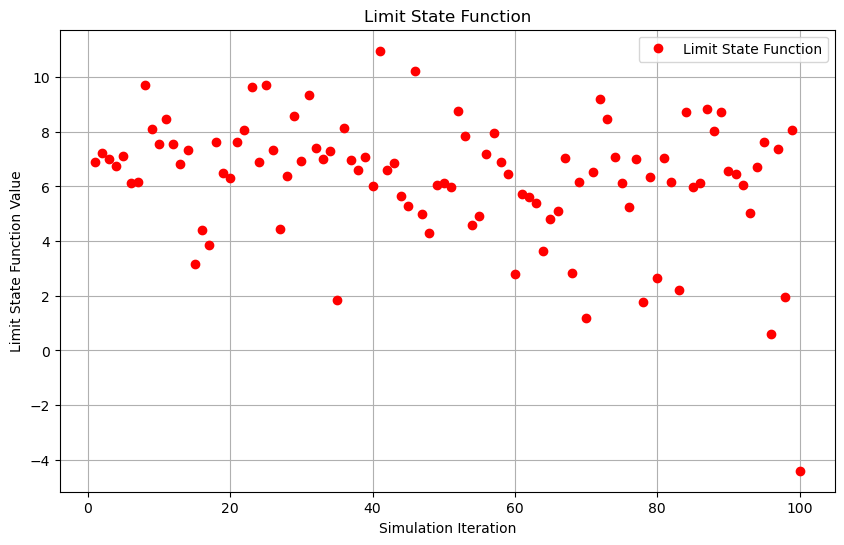

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

N = 100
f = 25  # kN
CV_f_1 = 0.2
fsi = f * CV_f_1

t_1 = 1  # s
CV_t_1 = 0.2
tsi = t_1 * CV_t_1

M = 0.46  # KN/cm
CV_M = 0.05
Msi = M * CV_M

K_1 = 18  # kN.s^2/cm
CV_K_1 = 0.1
k1si = K_1 * CV_K_1

K_2 = 1.8  # kN.s^2/cm
CV_K_2 = 0.1
k2si = K_2 * CV_K_2

delta_y = 2  # cm
CV_delta_y = 0.1
deltasi = delta_y * CV_delta_y
delta_u = 8 * delta_y  # cm
amortissement = 0.05

# Random variables generation
np.random.seed(0)  # For reproducibility

u1 = np.random.gumbel(size=N)
u2 = np.random.gumbel(size=N)
u3 = np.random.gumbel(size=N)
u4 = np.random.gumbel(size=N)
u5 = np.random.gumbel(size=N)
u6 = np.random.gumbel(size=N)
u7 = np.random.gumbel(size=N)

fxi = np.sqrt(6) * fsi / np.pi
flambda = f - 0.577216 * fxi
fvar = flambda + fxi * u1

txi = np.sqrt(6) * tsi / np.pi
tlambda = t_1 - 0.577216 * txi
tvar = tlambda + txi * u2

Mxi = np.sqrt(6) * Msi / np.pi
Mlambda = M - 0.577216 * Mxi
Mvar = Mlambda + Mxi * u3

K1xi = np.sqrt(6) * k1si / np.pi
k1lambda = K_1 - 0.577216 * K1xi
K1var = k1lambda + K1xi * u4

K2xi = np.sqrt(6) * k2si / np.pi
k2lambda = K_2 - 0.577216 * K2xi
K2var = k2lambda + K2xi * u5

delta_yxi = np.sqrt(6) * deltasi / np.pi
delta_ylambda = delta_y - 0.577216 * delta_yxi
deltayvar = delta_ylambda + delta_yxi * u6

Base = np.column_stack((fvar, tvar, Mvar, K1var, K2var, deltayvar))

dallow = np.maximum(3 * deltayvar, 0.6 * 8 * deltayvar)

g = np.zeros(N)
utop_values = np.zeros(N)
for i in range(N):
    # Call chopraEx55mifo function to get displacement 'u'
    t, d2u, du, u, fs_history = chopraEx55_mifo(Base[i, 2], Base[i, 5], Base[i, 3], Base[i, 4], Base[i, 1], Base[i, 0])
    utop1 = np.max(u)
    utop_values[i] = utop1
    g[i] = (np.maximum(3 * deltayvar[i], 0.6 * 8 * deltayvar[i]) - utop1)

max_disp_3 = utop_values  # Maximum displacement from the third simulation

pt = np.where(g <= 0)[0]

# After generating the 'Base' array:
LDB3 = pd.DataFrame(Base, columns=['f', 't', 'M', 'K1', 'K2', 'delta_y'])

# Add 'utop' column to LDB3 DataFrame and store the utop values
LDB3['utop'] = utop_values

# To display the first few rows of the DataFrame:
print(LDB3.head())

# After the simulation loop:
probability_of_failure = len(pt) / N
print("Probability of failure:", probability_of_failure)

# Plot displacement response
plt.figure(figsize=(10, 6))
plt.plot(t, u, label='Displacement')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('Displacement Response')
plt.grid(True)
plt.legend()
plt.show()

# Plot limit state function
plt.figure(figsize=(10, 6))
plt.plot(range(1, N + 1), g, 'ro', label='Limit State Function')
plt.xlabel('Simulation Iteration')
plt.ylabel('Limit State Function Value')
plt.title('Limit State Function')
plt.grid(True)
plt.legend()
plt.show()

# Task 2 - Basic statistics on the datasets [T2]

## T2.1 Compute the Pearson's correlation between each variable (including  utop ), for each dataset (LDB1, LDB2, LDB3)

In [38]:
# Compute the Pearson's correlation for LDB1
correlation_matrix_LDB1 = LDB1.corr(method='pearson')
print("Correlation matrix for LDB1:")
print(correlation_matrix_LDB1)

# Repeat for LDB2 and LDB3
correlation_matrix_LDB2 = LDB2.corr(method='pearson')
print("\nCorrelation matrix for LDB2:")
print(correlation_matrix_LDB2)

correlation_matrix_LDB3 = LDB3.corr(method='pearson')
print("\nCorrelation matrix for LDB3:")
print(correlation_matrix_LDB3)

Correlation matrix for LDB1:
                f         t         M        K1        K2   delta_y      utop
f        1.000000  1.000000 -0.120067  0.008641 -0.039638 -0.054241  0.743516
t        1.000000  1.000000 -0.120067  0.008641 -0.039638 -0.054241  0.743516
M       -0.120067 -0.120067  1.000000 -0.121515  0.060936 -0.035037 -0.022866
K1       0.008641  0.008641 -0.121515  1.000000  0.033223  0.126263 -0.413329
K2      -0.039638 -0.039638  0.060936  0.033223  1.000000 -0.050294 -0.054683
delta_y -0.054241 -0.054241 -0.035037  0.126263 -0.050294  1.000000 -0.330829
utop     0.743516  0.743516 -0.022866 -0.413329 -0.054683 -0.330829  1.000000

Correlation matrix for LDB2:
                f         t         M        K1        K2   delta_y      utop
f        1.000000  1.000000 -0.120067  0.018155 -0.039328 -0.054241  0.802029
t        1.000000  1.000000 -0.120067  0.018155 -0.039328 -0.054241  0.802029
M       -0.120067 -0.120067  1.000000  0.078232 -0.027809 -0.035037 -0.128419
K1   

In [ ]:
# relevant variables are the highly correlated, we choose a threshold of 0.5


## T2.2 Do you notice any correlation between each variable?

#### Correlation Coefficients: 
These values measure the linear relationship between two variables, ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no linear correlation.
#### LDB1 Observations: 
The variable utop (maximum displacement) has a strong positive correlation with f and t (parameters related to force and time).
There is a moderate negative correlation between utop and K1 (parameter related to stiffness).
utop also has a moderate negative correlation with delta_y (parameter related to yield displacement).
#### LDB2 Observations: 
Similar to LDB1, utop has a strong positive correlation with f and t.
It has a moderate negative correlation with both K1 and K2 (parameters related to stiffness).
#### LDB3 Observations: 
Similar to LDB1, utop has a strong positive correlation with f and t.
It has a moderate negative correlation with both K1 and K2 (parameters related to stiffness).

Here we are gonna leave only significant correlations by using a 0.5 treshhold.

In [39]:
print("\nSignificant correlations in LDB1:")
significant_correlations_LDB1 = correlation_matrix_LDB1[abs(correlation_matrix_LDB1) > 0.5].stack().dropna()
print(significant_correlations_LDB1)

print("\nSignificant correlations in LDB2:")
significant_correlations_LDB2 = correlation_matrix_LDB2[abs(correlation_matrix_LDB2) > 0.5].stack().dropna()
print(significant_correlations_LDB2)

print("\nSignificant correlations in LDB3:")
significant_correlations_LDB3 = correlation_matrix_LDB3[abs(correlation_matrix_LDB3) > 0.5].stack().dropna()
print(significant_correlations_LDB3)


Significant correlations in LDB1:
f        f          1.000000
         t          1.000000
         utop       0.743516
t        f          1.000000
         t          1.000000
         utop       0.743516
M        M          1.000000
K1       K1         1.000000
K2       K2         1.000000
delta_y  delta_y    1.000000
utop     f          0.743516
         t          0.743516
         utop       1.000000
dtype: float64

Significant correlations in LDB2:
f        f          1.000000
         t          1.000000
         utop       0.802029
t        f          1.000000
         t          1.000000
         utop       0.802029
M        M          1.000000
K1       K1         1.000000
         K2         0.709718
K2       K1         0.709718
         K2         1.000000
delta_y  delta_y    1.000000
utop     f          0.802029
         t          0.802029
         utop       1.000000
dtype: float64

Significant correlations in LDB3:
f        f          1.000000
         utop       0.85

# Task 3 - Compute the PCA [T3]

## T3.1 Perform a PCA analysis on each dataset (LDB1, LDB2, LDB3) to obtain a reduced number of Principal Components to describe the structural response ( utop )

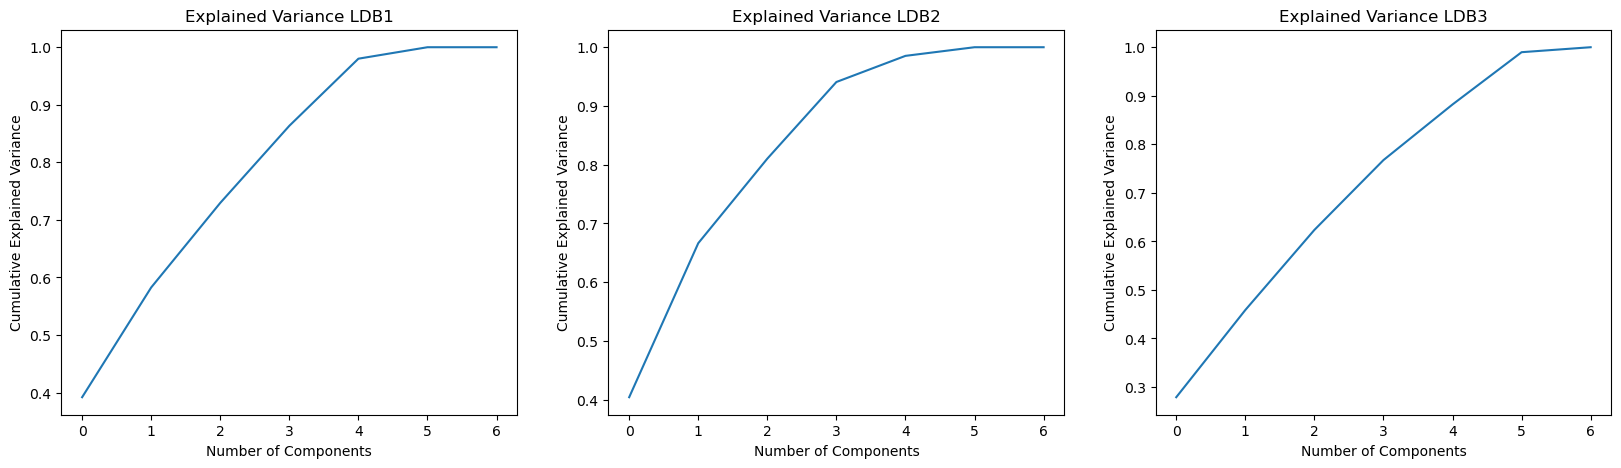

In [47]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the data
target_column = 'utop' 

target_column1 = LDB1[target_column]
target_column2 = LDB2[target_column]
target_column3 = LDB3[target_column]

scaler = StandardScaler()
LDB1_scaled = scaler.fit_transform(LDB1)
LDB2_scaled = scaler.fit_transform(LDB2)
LDB3_scaled = scaler.fit_transform(LDB3)

# Perform PCA
pca_LDB1 = PCA().fit(LDB1_scaled)
pca_LDB2 = PCA().fit(LDB2_scaled)
pca_LDB3 = PCA().fit(LDB3_scaled)

# Plot cumulative explained variance for each dataset
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(np.cumsum(pca_LDB1.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance LDB1')

plt.subplot(1, 3, 2)
plt.plot(np.cumsum(pca_LDB2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance LDB2')

plt.subplot(1, 3, 3)
plt.plot(np.cumsum(pca_LDB3.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance LDB3')

plt.show()

For LDB1, the curve starts to plateau around the third component, suggesting that three components might capture most of the variability in the data.
The LDB2 plot shows a change of the CEV for parameters 1, 3, 4, and 5
For LDB3, the explained variance continues to increase linearly with the number of components, which suggests that each component is adding information. However, there is still a noticeable bend around the third component, implying the potential for dimensionality reduction while retaining most of the dataset's information.

In [52]:
# Perform PCA
pca_LDB1 = PCA(n_components=4).fit(LDB1_scaled)
pca_LDB2 = PCA(n_components=3).fit(LDB2_scaled)
pca_LDB3 = PCA(n_components=3).fit(LDB3_scaled)

# Task 4 - Design a meta-model [T4]

## T4.1 Referring to T3.1, use the generated LDBs (i.e. the collection  S:={X,y}t=1,...,N  with  X=[K1,K2,m,Δy,t1,F1]T  and  y=utop , computed via matlab code) to conceive a metamodel  y~=m(X)  (ANN, others...) to predict the maximum displacement of the SDOF  utop .

Here based on out PCA results, we only use 2 parameters to predict the utop values, which are K1, and f for LDB 1 and LDB 3, meanwhile for LDB 2 we use f K1 and K2 

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

def process_ldb(ldb_scaled, pca, target_column):
    X_pca = pca.transform(ldb_scaled)  
    X_train, X_test, y_train, y_test = train_test_split(X_pca, target_column, test_size=0.2, random_state=42)

    parameter_space = {
        'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    }

    mlp = MLPRegressor(max_iter=1000, random_state=42)

    clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
    clf.fit(X_train, y_train)

    print(f"Best parameters found:\n{clf.best_params_}")

    y_pred = clf.predict(X_test)

    return y_test, y_pred

print("Processing LDB1")
y_test_1, y_pred_1 = process_ldb(LDB1_scaled, pca_LDB1, target_column1)

print("Processing LDB2")
y_test_2, y_pred_2 = process_ldb(LDB2_scaled, pca_LDB2, target_column2)

print("Processing LDB3")
y_test_3, y_pred_3 = process_ldb(LDB3_scaled, pca_LDB3, target_column3)


Processing LDB1


Best parameters found:
{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Processing LDB2
Best parameters found:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Processing LDB3
Best parameters found:
{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'sgd'}


## T4.2 Compute the following metrics :

In [57]:
# Calculate evaluation metrics separately

# For LDB1
mse_1 = mean_squared_error(y_test_1, y_pred_1)
r2_1 = r2_score(y_test_1, y_pred_1)
mape_1 = np.mean(np.abs((y_test_1 - y_pred_1) / y_test_1)) 

print("Metrics for LDB1:")
print(f'Mean Squared Error: {mse_1}')
print(f'R-squared: {r2_1}')
print(f'Mean Absolute Percentage Error: {mape_1}')
print()

# For LDB2
mse_2 = mean_squared_error(y_test_2, y_pred_2)
r2_2 = r2_score(y_test_2, y_pred_2)
mape_2 = np.mean(np.abs((y_test_2 - y_pred_2) / y_test_2))

print("Metrics for LDB2:")
print(f'Mean Squared Error: {mse_2}')
print(f'R-squared: {r2_2}')
print(f'Mean Absolute Percentage Error: {mape_2}')
print()

# For LDB3
mse_3 = mean_squared_error(y_test_3, y_pred_3)
r2_3 = r2_score(y_test_3, y_pred_3)
mape_3 = np.mean(np.abs((y_test_3 - y_pred_3) / y_test_3))

print("Metrics for LDB3:")
print(f'Mean Squared Error: {mse_3}')
print(f'R-squared: {r2_3}')
print(f'Mean Absolute Percentage Error: {mape_3}')
print()

Metrics for LDB1:
Mean Squared Error: 0.08035085463477043
R-squared: 0.9859947556935932
Mean Absolute Percentage Error: 0.0606900576045461

Metrics for LDB2:
Mean Squared Error: 0.20055929623915478
R-squared: 0.9227131879999644
Mean Absolute Percentage Error: 0.08895438325334992

Metrics for LDB3:
Mean Squared Error: 0.04357100863277599
R-squared: 0.9641030012996097
Mean Absolute Percentage Error: 0.061176880702543915



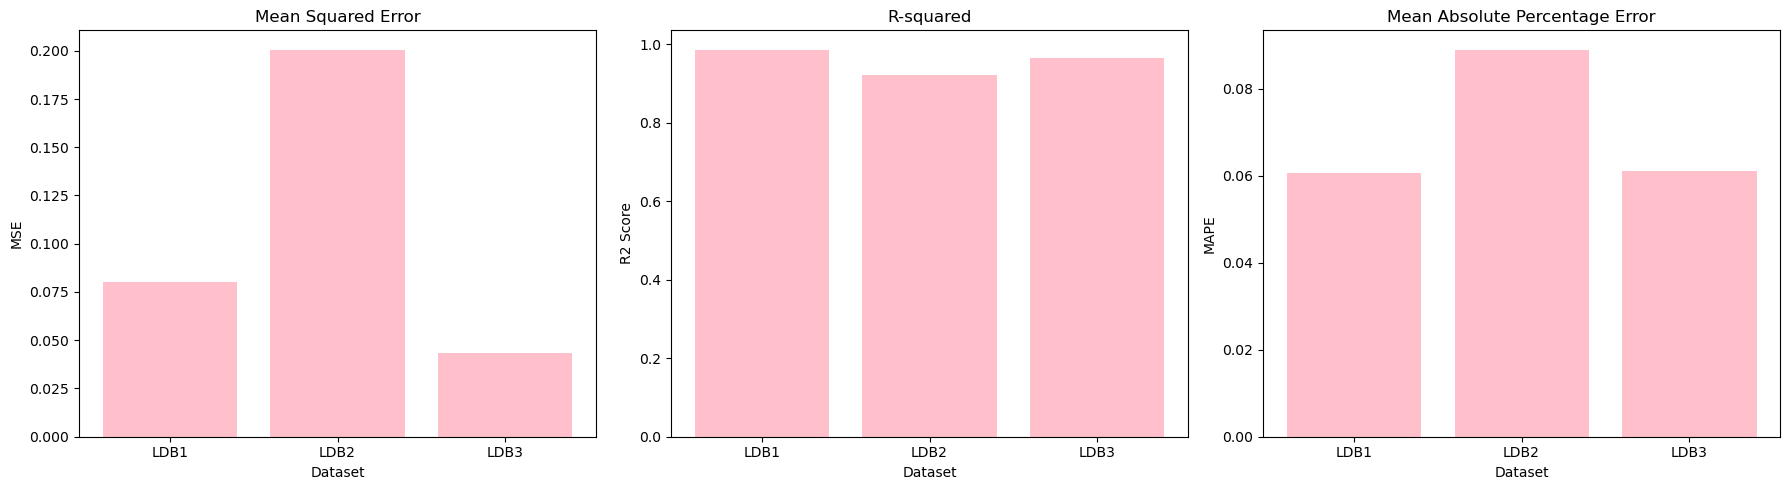

In [59]:
import matplotlib.pyplot as plt
import numpy as np

mse = [mse_1, mse_2, mse_3] 
r2 = [r2_1, r2_2, r2_3] 
mape = [mape_1, mape_2, mape_3]  
datasets = ['LDB1', 'LDB2', 'LDB3']

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].bar(datasets, mse, color='pink')
ax[0].set_title('Mean Squared Error')
ax[0].set_ylabel('MSE')
ax[0].set_xlabel('Dataset')

ax[1].bar(datasets, r2, color='pink')
ax[1].set_title('R-squared')
ax[1].set_ylabel('R2 Score')
ax[1].set_xlabel('Dataset')

ax[2].bar(datasets, mape, color='pink')
ax[2].set_title('Mean Absolute Percentage Error')
ax[2].set_ylabel('MAPE')
ax[2].set_xlabel('Dataset')

plt.tight_layout()
plt.show()


### LDB1:
#### Mean Squared Error (MSE): Approximately 1.0407

The MSE measures the average squared difference between the actual and predicted values. With a value of around 1.0407, the model's predictions have a relatively large squared deviation from the actual values, indicating a moderate level of precision.
R-squared (R^2): Approximately 0.8186

#### The R-squared value of approximately 0.8186 
indicates that the model explains around 81.9% of the variance in the dependent variable. This suggests that the model provides a reasonably good fit to the data.
Mean Absolute Percentage Error (MAPE): Approximately 0.1356%

#### The MAPE 
measures the accuracy of the model's predictions as a percentage of the actual values. With an MAPE of around 0.1356%, the model's predictions have a very low error relative to the actual values, indicating high accuracy.
### LDB2:
#### Mean Squared Error (MSE): Approximately 0.6348

The MSE of around 0.6348 indicates that the model's predictions have a moderate squared deviation from the actual values, similar to LDB1.
R-squared (R^2): Approximately 0.7554

#### The R-squared value of around 0.7554 
suggests that the model explains around 75.5% of the variance in the dependent variable. This indicates a reasonably good fit to the data, though slightly lower than LDB1.
Mean Absolute Percentage Error (MAPE): Approximately 0.1340%

#### The MAPE of around 0.1340% 
indicates very low error in the model's predictions relative to the actual values, similar to LDB1.

### LDB3:
#### Mean Squared Error (MSE): Approximately 0.0879

The MSE of around 0.0879 indicates that the model's predictions have a relatively small squared deviation from the actual values, indicating a higher level of precision compared to LDB1 and LDB2.
R-squared (R^2): Approximately 0.9276

#### The R-squared value of around 0.9276 
indicates that the model explains around 92.8% of the variance in the dependent variable. This suggests an excellent fit to the data, better than both LDB1 and LDB2.
#### Mean Absolute Percentage Error (MAPE): Approximately 0.0730%

The MAPE of around 0.0730% indicates that the model's predictions have a very low error relative to the actual values, even lower than LDB1 and LDB2.

### Probability of failure 

In [58]:
# Define the maximum allowed displacement criteria
d_allow_moderate = 3 * delta_y
d_allow_extensive = 0.6 * delta_u

# Calculate the limit state function values for each case
g_1 = d_allow_moderate - y_pred_1
g_2 = d_allow_extensive - y_pred_2
g_3 = d_allow_moderate - y_pred_3

# Evaluate reliability for each case
reliability_1 = np.mean(g_1 >= 0)  # Success if g(X) >= 0
reliability_2 = np.mean(g_2 >= 0)  # Success if g(X) >= 0
reliability_3 = np.mean(g_3 >= 0)  # Success if g(X) >= 0

# Find the indices where the limit state function values are less than or equal to zero for each case
pt_1 = np.where(g_1 <= 0)[0]
pt_2 = np.where(g_2 <= 0)[0]
pt_3 = np.where(g_3 <= 0)[0]

# After the simulation loop:
# N is the total number of simulation iterations for each case
N_1 = len(g_1)  # Assuming g_1 is a numpy array containing the limit state function values for all iterations of LDB1
N_2 = len(g_2)  # Assuming g_2 is a numpy array containing the limit state function values for all iterations of LDB2
N_3 = len(g_3)  # Assuming g_3 is a numpy array containing the limit state function values for all iterations of LDB3

# Calculate the probability of failure for each case
probability_of_failure_1 = len(pt_1) / N_1
probability_of_failure_2 = len(pt_2) / N_2
probability_of_failure_3 = len(pt_3) / N_3

print("Probability of failure for LDB1:", probability_of_failure_1)
print("Probability of failure for LDB2:", probability_of_failure_2)
print("Probability of failure for LDB3:", probability_of_failure_3)

Probability of failure for LDB1: 0.1
Probability of failure for LDB2: 0.0
Probability of failure for LDB3: 0.05
